In [2]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob

#import geopandas as gpd
import pandas as pd

import sys
sys.path.append('../')


import utils.basics as bsc
import utils.plotting as pt

import importlib
importlib.reload(pt)

%load_ext autoreload
%autoreload 2


## Loading files

In [41]:
# PATHS
S2_stacked_1_raw = "../data/02_processed/S2_Stacked_Site_1.tif"
S2_stacked_2_raw = "../data/02_processed/S2_Stacked_Site_2.tif"

# rather take the normalized S2 stacks
# === INPUT Paths ===
S2_stacked_1 = "../data/02_processed/S2_Stacked_Site_1_norm.tif"
S2_stacked_2 = "../data/02_processed/S2_Stacked_Site_2_norm.tif"

ALS_PATH1_RES = "../data/02_processed/ALS_resampled_site1.tif"
ALS_PATH2_RES = "../data/02_processed/ALS_resampled_site2.tif"


# === OUTPUT Paths ===
OUTPUT_FOLDER = "../data/03_training"
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

In [42]:
# Load S2 and merged ALS data for both sites and combine them in an array
s2_np, als_np = bsc.load_rasters(S2_stacked_1, ALS_PATH1_RES,verbose=False)
s2_np2, als_np2 = bsc.load_rasters(S2_stacked_2, ALS_PATH2_RES,verbose=False)

s2_np_raw, als_np = bsc.load_rasters(S2_stacked_1_raw, ALS_PATH1_RES,verbose=False)
s2_np2_raw, als_np2 = bsc.load_rasters(S2_stacked_2_raw, ALS_PATH2_RES,verbose=False)

In [ ]:
# TO-DO: Fix nan count introduced by normalization
print("S2 Site 1 NaN count:", np.isnan(s2_np).sum())
print("S2 Site 1 NaN count:", np.isnan(s2_np_raw).sum())

S2 Site 1 NaN count: 5197285
S2 Site 1 NaN count: 0


## Do Patch extraction

In [37]:
def extract_patches_with_resampled_data(s2, als, patch_size, only_full_patches=False,verbose=True):
    """
    Extract patches from S2 data and resampled ALS data.

    Parameters:
    - s2: numpy array of S2 data (bands, height, width)
    - als: numpy array of resampled ALS values (height, width)
    - patch_size: size of the patches to extract
    - only_full_patches: if True, only return patches with no NaN/missing data

    Returns:
    - s2_patches: numpy array of S2 patches
    - als_patches: numpy array of ALS ground truth patches
    - combined_patches: numpy array of combined patches (S2 + ALS as additional band)
    """
    _, h, w = s2.shape
    patches_s2, patches_als, combined_patches = [], [], []
    full_patch_count = 0

    for i in range(0, h - patch_size + 1, patch_size):
        for j in range(0, w - patch_size + 1, patch_size):
            s2_patch = s2[:, i:i+patch_size, j:j+patch_size]
            als_patch = als[i:i+patch_size, j:j+patch_size]

            combined_patch = np.concatenate(
                [s2_patch, als_patch[np.newaxis, :, :]], axis=0
            )

            has_nan = np.isnan(combined_patch).any()
            if not has_nan:
                full_patch_count += 1

            if only_full_patches and has_nan:
                continue

            patches_s2.append(s2_patch)
            patches_als.append(als_patch)
            combined_patches.append(combined_patch)

    s2_arr = np.stack(patches_s2) if patches_s2 else np.empty((0, s2.shape[0], patch_size, patch_size))
    als_arr = np.stack(patches_als) if patches_als else np.empty((0, patch_size, patch_size))
    combined_arr = np.stack(combined_patches) if combined_patches else np.empty((0, s2.shape[0]+1, patch_size, patch_size))
    if verbose:
        print(f"Patch size: {patch_size}, Number of patches: {len(s2_arr)}, Full patches (no NaN): {full_patch_count}")
    return s2_arr, als_arr, combined_arr


In [38]:
patches = [16,32,64,128,256]
s2 = [s2_np, s2_np2]
als = [als_np, als_np2]
i = 0
for s2, als in zip(s2, als):
    i+= 1
    print(f"Processing site {i}...")
    print("---------------------")
    print(f"S2 shape: {s2.shape}, ALS shape: {als.shape}")
    for p in patches:
        #print(f"Extracting patches of size {p}...")
        s2_arr, als_arr, combined_arr = extract_patches_with_resampled_data(s2, als, p, only_full_patches=False)
    print("---------------------")

Processing site 1...
---------------------
S2 shape: (13, 846, 1241), ALS shape: (846, 1241)
Patch size: 16, Number of patches: 4004, Full patches (no NaN): 965
Patch size: 32, Number of patches: 988, Full patches (no NaN): 196
Patch size: 64, Number of patches: 247, Full patches (no NaN): 34
Patch size: 128, Number of patches: 54, Full patches (no NaN): 3
Patch size: 256, Number of patches: 12, Full patches (no NaN): 0
---------------------
Processing site 2...
---------------------
S2 shape: (13, 1002, 815), ALS shape: (1002, 815)
Patch size: 16, Number of patches: 3100, Full patches (no NaN): 1301
Patch size: 32, Number of patches: 775, Full patches (no NaN): 261
Patch size: 64, Number of patches: 180, Full patches (no NaN): 40
Patch size: 128, Number of patches: 42, Full patches (no NaN): 4
Patch size: 256, Number of patches: 9, Full patches (no NaN): 0
---------------------


In [7]:
# write a function to save the patches as numpy arrays
def save_patches_as_npy(s2, als, output_folder, patch_size, site_number):
    """
    Save the extracted patches as numpy arrays.

    Parameters:
    - s2: numpy array of S2 data (bands, height, width)
    - als: numpy array of resampled ALS values (height, width)
    - patch_size: size of the patches to extract
    - site_number: site number (1 or 2)
    """
    s2_patches, als_patches, combined_patches = extract_patches_with_resampled_data(s2, als, patch_size, only_full_patches=True, verbose=False)

    np.save(os.path.join(output_folder, f"S2_site{site_number}_px{patch_size}.npy"), s2_patches)
    np.save(os.path.join(output_folder, f"ALS_site{site_number}_px{patch_size}.npy"), als_patches)
    np.save(os.path.join(output_folder, f"S2_ALS_site{site_number}_px{patch_size}.npy"), combined_patches)

    print(f"Patches saved for site {site_number}, patch size {patch_size}.")

In [8]:
save_patches_as_npy(s2_np, als_np, OUTPUT_FOLDER, 32, 1)
save_patches_as_npy(s2_np2, als_np2, OUTPUT_FOLDER, 32, 2)

Patches saved for site 1, patch size 32.
Patches saved for site 2, patch size 32.


## some intuitiuon plotting

Patch size: 32, Number of patches: 261, Full patches (no NaN): 261


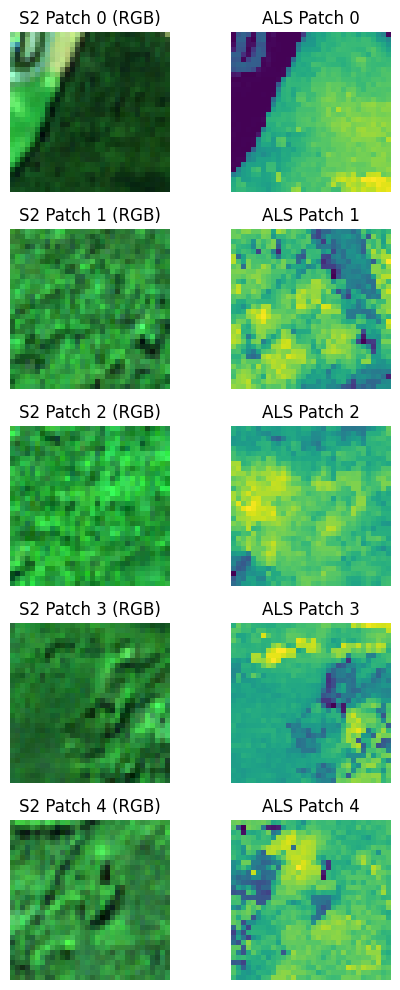

In [9]:
p = 32
s2 = s2_np2 #[s2_np, 
als = als_np2 #[als_np, als_np2]

s2_arr, als_arr, combined_arr = extract_patches_with_resampled_data(s2, als, p, only_full_patches=True)

# plot some patches directly here
n_patches = 5
fig, axes = plt.subplots(n_patches, 2, figsize=(5, 2 * n_patches))

for idx in range(n_patches):
    # S2 RGB composite (bands 10, 3, 0 if available)
    if s2_arr.shape[1] >= 4:
        rgb = np.stack([
            s2_arr[idx, 10],  # band 10 (red)
            s2_arr[idx, 3],  # band 3 (green)
            s2_arr[idx, 0],  # band 0 (blue)
        ], axis=-1)
        #rgb = (rgb - np.nanmin(rgb)) / (np.nanmax(rgb) - np.nanmin(rgb) + 1e-6)
        # rgb is already normalized between 0 and 1, so maybe rgb plotting is too dark. adjusting it:
        rgb = (rgb - np.nanmin(rgb)) / (np.nanmax(rgb) - np.nanmin(rgb) + 1e-6)
        # Ensure RGB values are in the range [0, 1]
        
        #rgb = np.clip(rgb, 0, 1)
        #rgb = (rgb * 255)#.astype(np.uint16)
        axes[idx, 0].imshow(rgb)
        axes[idx, 0].set_title(f"S2 Patch {idx} (RGB)")
    else:
        axes[idx, 0].imshow(s2_arr[idx, 0], cmap='gray')
        axes[idx, 0].set_title(f"S2 Patch {idx} (Band 0)")

    # ALS patch
    axes[idx, 1].imshow(als_arr[idx], cmap='viridis')
    axes[idx, 1].set_title(f"ALS Patch {idx}")


    for j in range(2):
        axes[idx, j].axis('off')

plt.tight_layout()
plt.show()


In [10]:
def load_and_split_patches(site, patch_size=32, test_size=0.2, random_state=42):
    """
    Load S2 and ALS patches for a given site, split into train/test sets.

    Parameters:
    - site: int (1 or 2)
    - patch_size: int
    - test_size: float
    - random_state: int

    Returns:
    - X_train, X_test, y_train, y_test
    """
    s2_patches = np.load(os.path.join(OUTPUT_FOLDER, f"S2_site{site}_px{patch_size}.npy"))
    als_patches = np.load(os.path.join(OUTPUT_FOLDER, f"ALS_site{site}_px{patch_size}.npy"))
    X_train, X_test, y_train, y_test = train_test_split(
        s2_patches, als_patches, test_size=test_size, random_state=random_state
    )
    print(f"Site {site}: X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"Site {site}: X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
    return X_train, X_test, y_train, y_test

# Execute for site 1 and 2
X_train1, X_test1, y_train1, y_test1 = load_and_split_patches(site=1)
X_train2, X_test2, y_train2, y_test2 = load_and_split_patches(site=2)

Site 1: X_train shape: (156, 13, 32, 32), y_train shape: (156, 32, 32)
Site 1: X_test shape: (40, 13, 32, 32), y_test shape: (40, 32, 32)
Site 2: X_train shape: (208, 13, 32, 32), y_train shape: (208, 32, 32)
Site 2: X_test shape: (53, 13, 32, 32), y_test shape: (53, 32, 32)


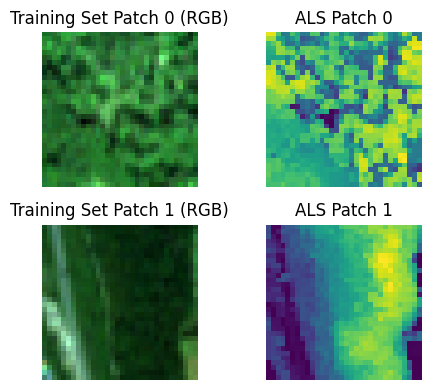

In [11]:
# Now we can visualize the training and test sets
def plot_patches(X, Y, title, n_patches=5):
    fig, axes = plt.subplots(n_patches, 2, figsize=(5, 2 * n_patches))
    for idx in range(n_patches):
        # S2 RGB composite (bands 10, 3, 0 if available)
        if X.shape[1] >= 4:
            rgb = np.stack([
                X[idx, 10],  # band 10 (red)
                X[idx, 3],   # band 3 (green)
                X[idx, 0],   # band 0 (blue)
            ], axis=-1)
            rgb = (rgb - np.nanmin(rgb)) / (np.nanmax(rgb) - np.nanmin(rgb) + 1e-6)
            axes[idx, 0].imshow(rgb)
            axes[idx, 0].set_title(f"{title} Patch {idx} (RGB)")
        else:
            axes[idx, 0].imshow(X[idx, 0], cmap='gray')
            axes[idx, 0].set_title(f"{title} Patch {idx} (Band 0)")

        # ALS patch
        axes[idx, 1].imshow(Y[idx], cmap='viridis')
        axes[idx, 1].set_title(f"ALS Patch {idx}")

        for j in range(2):
            axes[idx, j].axis('off')

    plt.tight_layout()
    plt.show()
# Plot the training patches
plot_patches(X_train2, y_train2, "Training Set", n_patches=2)
# Plot the test patches
#plot_patches(X_test, "Test Set", n_patches=5)

## lets have a look at the 3D surface of the ALS

In [12]:
# write a function that plots some 3D figure of the ALS data for some patches
def plot_als_3d_patches(als_patches, n_patches=5):
    """
    Plot 3D ALS patches.

    Parameters:
    - als_patches: numpy array of ALS patches (num_patches, height, width)
    - n_patches: number of patches to plot
    """
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(figsize=(10, 10))
    for idx in range(n_patches):
        ax = fig.add_subplot(n_patches, 1, idx + 1, projection='3d')
        als_patch = als_patches[idx]
        x = np.arange(als_patch.shape[1])
        y = np.arange(als_patch.shape[0])
        X, Y = np.meshgrid(x, y)
        ax.plot_surface(X, Y, als_patch, cmap='viridis')
        ax.set_title(f"ALS Patch {idx} (3D View)")
        ax.set_xlabel('Width')
        ax.set_ylabel('Height')
        ax.set_zlabel('ALS Value')

    plt.tight_layout()
    plt.show()
# Plot 3D ALS patches for the first 5 patches of site 1


In [ ]:
p=16
_, als_resp, _ = extract_patches_with_resampled_data(s2_np, als_np, p, only_full_patches=True)

Patch size: 8, Number of patches: 4309, Full patches (no NaN): 4309


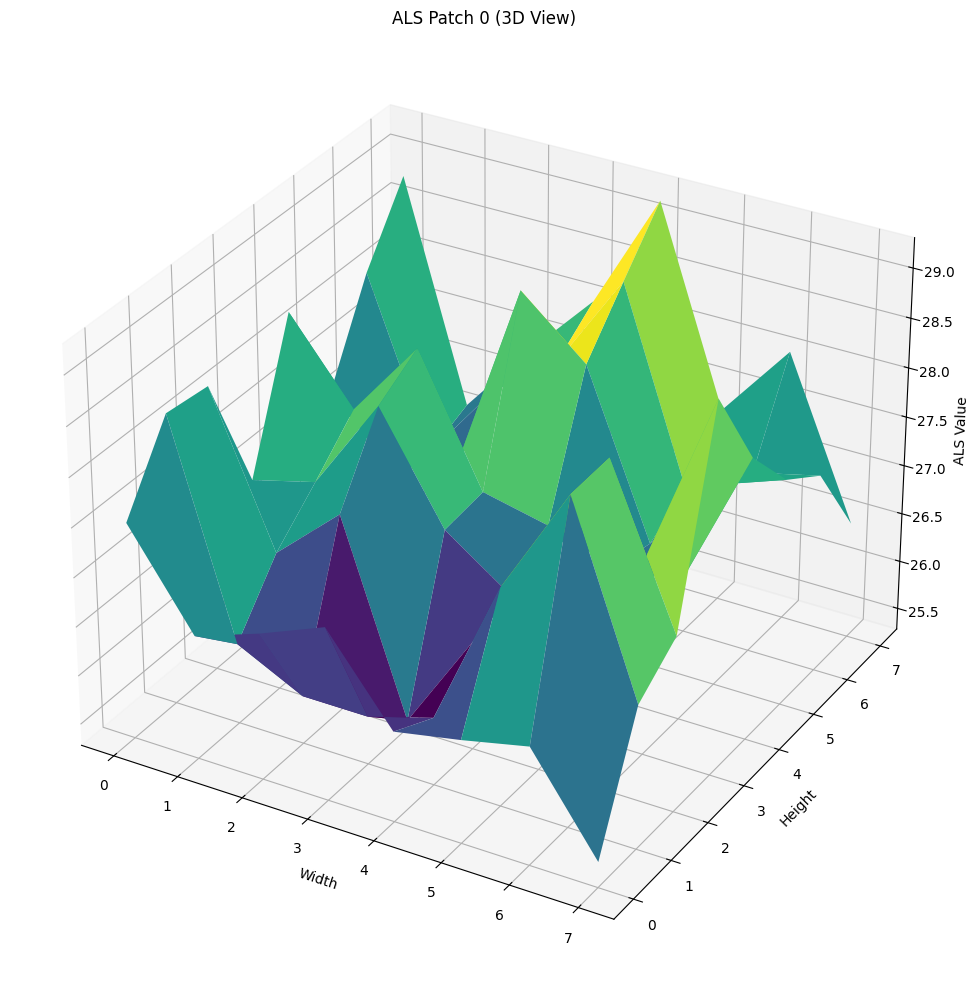

In [30]:
plot_als_3d_patches(als_resp[2:], n_patches=1)